# LAB 3: How to setup a project from Scratch

In [1]:
!rm -rf speech-emotion-recognition-25

# Step 1: Clone your project from Github

In [2]:
#main
#!git clone https://github.com/MatteoPaglia/speech-emotion-recognition-25.git

#             nome branch

!git clone -b IemocapClass https://github.com/MatteoPaglia/speech-emotion-recognition-25.git

Cloning into 'speech-emotion-recognition-25'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 354 (delta 22), reused 16 (delta 7), pack-reused 316 (from 2)
Receiving objects: 100% (354/354), 2.09 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [3]:
!ls

sample_data  speech-emotion-recognition-25


In [4]:
# %cd mldl_project_skeleton
%cd speech-emotion-recognition-25

/content/speech-emotion-recognition-25


In [5]:
!ls

checkpoints  dataset  README.md			       train.py
config.py    eval.py  requirements.txt		       utils
data	     models   SpeechEmotionRecnognition.ipynb


# Step 2: Packages Installation


In [6]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:0000:0100:01


# Step 3: Dataset Setup
## Different options
- First one is downloading using a script that places the data in the download folder (usually recommended)
- Second one is uploading the dataset to your personal/institutional Google Drive and load it from there ([Read More](https://saturncloud.io/blog/google-colab-how-to-read-data-from-my-google-drive/))
- Place the download script directly here on colab

You are free to do as you please in this phase.


In [10]:
!python utils/download_dataset.py

--- 1. Configurazione Kaggle ---
Kaggle configurato con successo.

--- Download RAVDESS ---
Contatto KaggleHub per scaricare: uwrfkaggler/ravdess-emotional-speech-audio...
100% 429M/429M [00:07<00:00, 62.8MB/s]
Extracting files...
✓ Dataset scaricato nella cache di sistema: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
RAVDESS pronto in cache: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
Numero totale di file: 2880

--- Download IEMOCAP ---
Contatto KaggleHub per scaricare: dejolilandry/iemocapfullrelease...
✓ Dataset scaricato nella cache di sistema: /root/.cache/kagglehub/datasets/dejolilandry/iemocapfullrelease/versions/1
IEMOCAP pronto in cache: /root/.cache/kagglehub/datasets/dejolilandry/iemocapfullrelease/versions/1
Numero totale di file: 81249

RIEPILOGO DOWNLOAD
RAVDESS: ✅ Successo
IEMOCAP: ✅ Successo

🎉 Tutti i dataset sono stati scaricati con successo!


In [12]:
import os
from pathlib import Path

print("="*80)
print("🔍 RICERCA PERCORSI DATASET")
print("="*80)

# Percorsi possibili dove potrebbero essere i dataset
possible_paths = [
    Path.home() / '.cache' / 'kagglehub' / 'datasets',
    Path('/root/.cache/kagglehub/datasets'),
    Path('/tmp/kagglehub/datasets'),
    Path('./data'),
    Path('../data'),
    Path('../../data'),
]

# Aggiungi anche la directory corrente
possible_paths.append(Path.cwd())

print(f"\n📁 Directory corrente: {Path.cwd()}\n")

# Ricerca IEMOCAP
print("🔎 Ricerca IEMOCAP_full_release...")
iemocap_path = None
iemocap_found = False
for base_path in possible_paths:
    if base_path.exists():
        for root, dirs, files in os.walk(base_path):
            if 'IEMOCAP_full_release' in dirs:
                iemocap_path = Path(root) / 'IEMOCAP_full_release'
                print(f"✅ IEMOCAP trovato a: {iemocap_path}")
                iemocap_found = True
                break
    if iemocap_found:
        break

if not iemocap_found:
    print("❌ IEMOCAP non trovato nei percorsi standard")
    iemocap_path = None

# Ricerca RAVDESS
print("\n🔎 Ricerca ravdess-emotional-speech-audio...")
ravdess_path = None
ravdess_found = False
for base_path in possible_paths:
    if base_path.exists():
        for root, dirs, files in os.walk(base_path):
            if 'ravdess-emotional-speech-audio' in dirs:
                ravdess_path = Path(root) / 'ravdess-emotional-speech-audio'
                print(f"✅ RAVDESS trovato a: {ravdess_path}")
                ravdess_found = True
                break
    if ravdess_found:
        break

if not ravdess_found:
    print("❌ RAVDESS non trovato nei percorsi standard")
    ravdess_path = None

# Lista contenuti della directory data/ se esiste
print("\n📂 Contenuto della cartella 'data/' (se presente):")
data_dir = Path('./data')
if data_dir.exists():
    for item in data_dir.iterdir():
        print(f"   - {item.name}")
else:
    print("   ❌ Cartella 'data/' non trovata")

print("\n" + "="*80)
print("✅ VARIABILI SALVATE:")
print(f"   - iemocap_path = {iemocap_path}")
print(f"   - ravdess_path = {ravdess_path}")
print("="*80)

🔍 RICERCA PERCORSI DATASET

📁 Directory corrente: /content/speech-emotion-recognition-25

🔎 Ricerca IEMOCAP_full_release...
✅ IEMOCAP trovato a: /root/.cache/kagglehub/datasets/dejolilandry/iemocapfullrelease/versions/1/IEMOCAP_full_release

🔎 Ricerca ravdess-emotional-speech-audio...
✅ RAVDESS trovato a: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio

📂 Contenuto della cartella 'data/' (se presente):
   - .gitkeep

✅ VARIABILI SALVATE:
   - iemocap_path = /root/.cache/kagglehub/datasets/dejolilandry/iemocapfullrelease/versions/1/IEMOCAP_full_release
   - ravdess_path = /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio


In [13]:
from torch.utils.data import DataLoader
from dataset.custom_iemocap_dataset import CustomIEMOCAPDataset
from dataset.custom_ravdess_dataset import CustomRAVDESSDataset

print(f"////////////////////////////////////////////////////////////////////////////////////////////")
print(f"Dataset IEMOCAP")
print(f"////////////////////////////////////////////////////////////////////////////////////////////")

# Usa il percorso trovato in precedenza, altrimenti fallback
if iemocap_path and iemocap_path.exists():
    dataset_IEMOCAP_path = str(iemocap_path)
    print(f"✅ Usando percorso trovato: {dataset_IEMOCAP_path}")
else:
    dataset_IEMOCAP_path = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release'
    print(f"⚠️  Percorso non trovato, usando fallback: {dataset_IEMOCAP_path}")

# Create IEMOCAPdatasets
train_IEMOCAP_dataset = CustomIEMOCAPDataset(dataset_root=dataset_IEMOCAP_path, split='train')
val_IEMOCAP_dataset = CustomIEMOCAPDataset(dataset_root=dataset_IEMOCAP_path, split='validation')
test_IEMOCAP_dataset = CustomIEMOCAPDataset(dataset_root=dataset_IEMOCAP_path, split='test')

print(f"Train samples: {len(train_IEMOCAP_dataset)}")
print(f"Val samples: {len(val_IEMOCAP_dataset)}")
print(f"Test samples: {len(test_IEMOCAP_dataset)}")

# Create IEMOCAP DataLoaders
batch_size = 4
train_IEMOCAP_dataloader = DataLoader(train_IEMOCAP_dataset, batch_size=batch_size, shuffle=True)
val_IEMOCAP_dataloader = DataLoader(val_IEMOCAP_dataset, batch_size=batch_size, shuffle=False)
test_IEMOCAP_dataloader = DataLoader(test_IEMOCAP_dataset, batch_size=batch_size, shuffle=False)


print(f"////////////////////////////////////////////////////////////////////////////////////////////")
print(f"Dataset RAVDESS")
print(f"////////////////////////////////////////////////////////////////////////////////////////////")

# Usa il percorso trovato in precedenza, altrimenti fallback
if ravdess_path and ravdess_path.exists():
    dataset_RAVDESS_path = str(ravdess_path)
    print(f"✅ Usando percorso trovato: {dataset_RAVDESS_path}")
else:
    dataset_RAVDESS_path = '/kaggle/input/ravdess-emotional-speech-audio'
    print(f"⚠️  Percorso non trovato, usando fallback: {dataset_RAVDESS_path}")

# Create RAVDESS datasets
train_RAVDESS_dataset = CustomRAVDESSDataset(dataset_root=dataset_RAVDESS_path, split='train')
val_RAVDESS_dataset = CustomRAVDESSDataset(dataset_root=dataset_RAVDESS_path, split='validation')
test_RAVDESS_dataset = CustomRAVDESSDataset(dataset_root=dataset_RAVDESS_path, split='test')

print(f"Train samples: {len(train_RAVDESS_dataset)}")
print(f"Val samples: {len(val_RAVDESS_dataset)}")
print(f"Test samples: {len(test_RAVDESS_dataset)}")

# Create RAVDESS DataLoaders
batch_size = 4
train_RAVDESS_dataloader = DataLoader(train_RAVDESS_dataset, batch_size=batch_size, shuffle=True)
val_RAVDESS_dataloader = DataLoader(val_RAVDESS_dataset, batch_size=batch_size, shuffle=False)
test_RAVDESS_dataloader = DataLoader(test_RAVDESS_dataset, batch_size=batch_size, shuffle=False)

////////////////////////////////////////////////////////////////////////////////////////////
Dataset IEMOCAP
////////////////////////////////////////////////////////////////////////////////////////////
✅ Usando percorso trovato: /root/.cache/kagglehub/datasets/dejolilandry/iemocapfullrelease/versions/1/IEMOCAP_full_release
✅ Caricate 4490 etichette
🔍 Raccogliendo campioni audio...
✅ Raccolti 2280 campioni audio
   - Solo campioni improvvisati
   - Emozioni: ['neutral', 'happy', 'sad', 'angry']
📊 Statistiche del dataset IEMOCAP:

📊 ANALISI IEMOCAP TRAINING SET


AttributeError: 'list' object has no attribute 'samples'

Loading IEMOCAP VALIDATION samples...

📊 Calcolando media durata POST-TRIMMING per split 'validation'...
   74/370 file processati...
   148/370 file processati...
   222/370 file processati...
   296/370 file processati...
   370/370 file processati...
✅ Media calcolata: 4.90s (78344 campioni)

Loading IEMOCAP TRAIN samples...

📊 Calcolando media durata POST-TRIMMING per split 'train'...
   270/1353 file processati...
   540/1353 file processati...
   810/1353 file processati...
   1080/1353 file processati...
   1350/1353 file processati...
✅ Media calcolata: 4.29s (68639 campioni)

Loading RAVDESS TRAIN samples...

📊 Calcolando media durata POST-TRIMMING per split 'train'...
   288/1440 file processati...
   576/1440 file processati...
   864/1440 file processati...
   1152/1440 file processati...
   1440/1440 file processati...
✅ Media calcolata: 2.19s (35043 campioni)



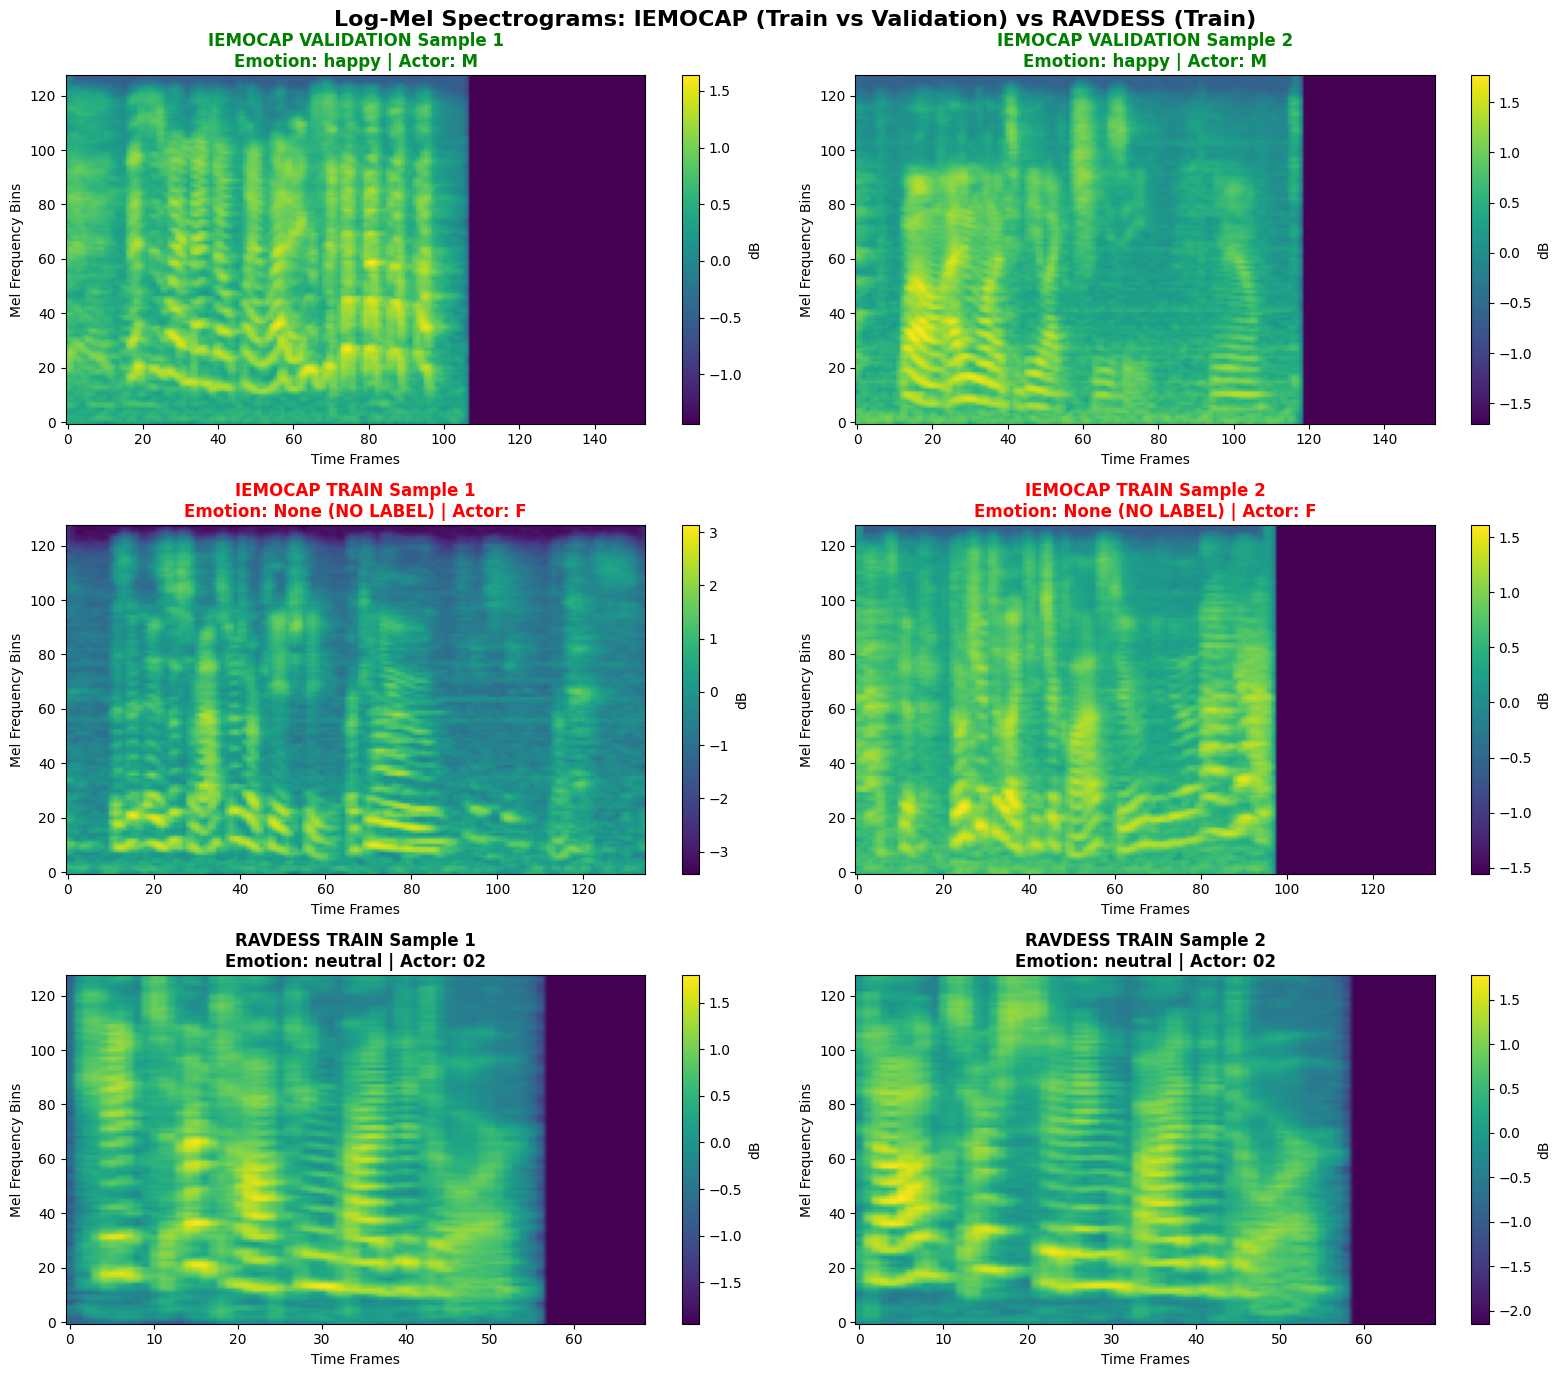


SAMPLE DETAILS

✅ IEMOCAP VALIDATION (con label):

📊 Sample 1:
   Emotion: happy (ID: 1)
   Actor: M
   Spectrogram Shape: torch.Size([1, 128, 154]) (channels, mel_bins, time_frames)
   Min value: -1.44 dB
   Max value: 1.64 dB
   Mean value: -0.00 dB

📊 Sample 2:
   Emotion: happy (ID: 1)
   Actor: M
   Spectrogram Shape: torch.Size([1, 128, 154])
   Min value: -1.70 dB
   Max value: 1.77 dB
   Mean value: -0.00 dB

❌ IEMOCAP TRAIN (SENZA label - Unsupervised):

📊 Sample 1:
   Emotion: None | Audio ID: 0
   Actor: F
   Spectrogram Shape: torch.Size([1, 128, 135])
   Min value: -3.41 dB
   Max value: 3.13 dB
   Mean value: -0.00 dB

📊 Sample 2:
   Emotion: None | Audio ID: 0
   Actor: F
   Spectrogram Shape: torch.Size([1, 128, 135])
   Min value: -1.55 dB
   Max value: 1.61 dB
   Mean value: 0.00 dB

✅ RAVDESS TRAIN (con label):

📊 Sample 1:
   Emotion: neutral (ID: 0)
   Actor: 02
   Spectrogram Shape: torch.Size([1, 128, 69])
   Min value: -1.95 dB
   Max value: 1.79 dB
   Mean val

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Colori per le emozioni
emotion_colors = {
    'neutral': '#4285F4',  # Blu
    'happy': '#34A853',    # Verde
    'sad': '#EA4335',      # Rosso
    'angry': '#FBBC04'     # Giallo/Arancione
}

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Log-Mel Spectrograms: IEMOCAP (Train vs Validation) vs RAVDESS (Train)', fontsize=16, fontweight='bold')

# ===== IEMOCAP - VALIDATION (ha le label) =====
print("Loading IEMOCAP VALIDATION samples...")
iemocap_val_sample_1 = val_IEMOCAP_dataset[0]
iemocap_val_sample_2 = val_IEMOCAP_dataset[1]

# Plot IEMOCAP Validation Sample 1
im1 = axes[0, 0].imshow(iemocap_val_sample_1['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title(f"IEMOCAP VALIDATION Sample 1\nEmotion: {iemocap_val_sample_1['emotion']} | Actor: {iemocap_val_sample_1['actor_id']}", 
                     fontweight='bold', color='green')
axes[0, 0].set_ylabel('Mel Frequency Bins')
axes[0, 0].set_xlabel('Time Frames')
plt.colorbar(im1, ax=axes[0, 0], label='dB')

# Plot IEMOCAP Validation Sample 2
im2 = axes[0, 1].imshow(iemocap_val_sample_2['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title(f"IEMOCAP VALIDATION Sample 2\nEmotion: {iemocap_val_sample_2['emotion']} | Actor: {iemocap_val_sample_2['actor_id']}", 
                     fontweight='bold', color='green')
axes[0, 1].set_ylabel('Mel Frequency Bins')
axes[0, 1].set_xlabel('Time Frames')
plt.colorbar(im2, ax=axes[0, 1], label='dB')

# ===== IEMOCAP - TRAIN (NO label) =====
print("Loading IEMOCAP TRAIN samples...")
iemocap_train_sample_1 = train_IEMOCAP_dataset[0]
iemocap_train_sample_2 = train_IEMOCAP_dataset[1]

# Plot IEMOCAP Train Sample 1
im3 = axes[1, 0].imshow(iemocap_train_sample_1['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title(f"IEMOCAP TRAIN Sample 1\nEmotion: {iemocap_train_sample_1['emotion']} (NO LABEL) | Actor: {iemocap_train_sample_1['actor_id']}", 
                     fontweight='bold', color='red')
axes[1, 0].set_ylabel('Mel Frequency Bins')
axes[1, 0].set_xlabel('Time Frames')
plt.colorbar(im3, ax=axes[1, 0], label='dB')

# Plot IEMOCAP Train Sample 2
im4 = axes[1, 1].imshow(iemocap_train_sample_2['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title(f"IEMOCAP TRAIN Sample 2\nEmotion: {iemocap_train_sample_2['emotion']} (NO LABEL) | Actor: {iemocap_train_sample_2['actor_id']}", 
                     fontweight='bold', color='red')
axes[1, 1].set_ylabel('Mel Frequency Bins')
axes[1, 1].set_xlabel('Time Frames')
plt.colorbar(im4, ax=axes[1, 1], label='dB')

# ===== RAVDESS - TRAIN =====
print("Loading RAVDESS TRAIN samples...")
ravdess_sample_1 = train_RAVDESS_dataset[0]
ravdess_sample_2 = train_RAVDESS_dataset[1]

# Plot RAVDESS Sample 1
im5 = axes[2, 0].imshow(ravdess_sample_1['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[2, 0].set_title(f"RAVDESS TRAIN Sample 1\nEmotion: {ravdess_sample_1['emotion']} | Actor: {ravdess_sample_1['actor_id']}", 
                     fontweight='bold')
axes[2, 0].set_ylabel('Mel Frequency Bins')
axes[2, 0].set_xlabel('Time Frames')
plt.colorbar(im5, ax=axes[2, 0], label='dB')

# Plot RAVDESS Sample 2
im6 = axes[2, 1].imshow(ravdess_sample_2['audio_features'].squeeze().numpy(), 
                        aspect='auto', origin='lower', cmap='viridis')
axes[2, 1].set_title(f"RAVDESS TRAIN Sample 2\nEmotion: {ravdess_sample_2['emotion']} | Actor: {ravdess_sample_2['actor_id']}", 
                     fontweight='bold')
axes[2, 1].set_ylabel('Mel Frequency Bins')
axes[2, 1].set_xlabel('Time Frames')
plt.colorbar(im6, ax=axes[2, 1], label='dB')

plt.tight_layout()
plt.show()

# ===== Stampa delle statistiche =====
print("\n" + "="*80)
print("SAMPLE DETAILS")
print("="*80)

print("\n✅ IEMOCAP VALIDATION (con label):")
print("\n📊 Sample 1:")
print(f"   Emotion: {iemocap_val_sample_1['emotion']} (ID: {iemocap_val_sample_1['emotion_id']})")
print(f"   Actor: {iemocap_val_sample_1['actor_id']}")
print(f"   Spectrogram Shape: {iemocap_val_sample_1['audio_features'].shape} (channels, mel_bins, time_frames)")
print(f"   Min value: {iemocap_val_sample_1['audio_features'].min().item():.2f} dB")
print(f"   Max value: {iemocap_val_sample_1['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {iemocap_val_sample_1['audio_features'].mean().item():.2f} dB")

print("\n📊 Sample 2:")
print(f"   Emotion: {iemocap_val_sample_2['emotion']} (ID: {iemocap_val_sample_2['emotion_id']})")
print(f"   Actor: {iemocap_val_sample_2['actor_id']}")
print(f"   Spectrogram Shape: {iemocap_val_sample_2['audio_features'].shape}")
print(f"   Min value: {iemocap_val_sample_2['audio_features'].min().item():.2f} dB")
print(f"   Max value: {iemocap_val_sample_2['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {iemocap_val_sample_2['audio_features'].mean().item():.2f} dB")

print("\n❌ IEMOCAP TRAIN (SENZA label - Unsupervised):")
print("\n📊 Sample 1:")
print(f"   Emotion: {iemocap_train_sample_1['emotion']} | Audio ID: {iemocap_train_sample_1['emotion_id']}")
print(f"   Actor: {iemocap_train_sample_1['actor_id']}")
print(f"   Spectrogram Shape: {iemocap_train_sample_1['audio_features'].shape}")
print(f"   Min value: {iemocap_train_sample_1['audio_features'].min().item():.2f} dB")
print(f"   Max value: {iemocap_train_sample_1['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {iemocap_train_sample_1['audio_features'].mean().item():.2f} dB")

print("\n📊 Sample 2:")
print(f"   Emotion: {iemocap_train_sample_2['emotion']} | Audio ID: {iemocap_train_sample_2['emotion_id']}")
print(f"   Actor: {iemocap_train_sample_2['actor_id']}")
print(f"   Spectrogram Shape: {iemocap_train_sample_2['audio_features'].shape}")
print(f"   Min value: {iemocap_train_sample_2['audio_features'].min().item():.2f} dB")
print(f"   Max value: {iemocap_train_sample_2['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {iemocap_train_sample_2['audio_features'].mean().item():.2f} dB")

print("\n✅ RAVDESS TRAIN (con label):")
print("\n📊 Sample 1:")
print(f"   Emotion: {ravdess_sample_1['emotion']} (ID: {ravdess_sample_1['emotion_id']})")
print(f"   Actor: {ravdess_sample_1['actor_id']}")
print(f"   Spectrogram Shape: {ravdess_sample_1['audio_features'].shape}")
print(f"   Min value: {ravdess_sample_1['audio_features'].min().item():.2f} dB")
print(f"   Max value: {ravdess_sample_1['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {ravdess_sample_1['audio_features'].mean().item():.2f} dB")

print("\n📊 Sample 2:")
print(f"   Emotion: {ravdess_sample_2['emotion']} (ID: {ravdess_sample_2['emotion_id']})")
print(f"   Actor: {ravdess_sample_2['actor_id']}")
print(f"   Spectrogram Shape: {ravdess_sample_2['audio_features'].shape}")
print(f"   Min value: {ravdess_sample_2['audio_features'].min().item():.2f} dB")
print(f"   Max value: {ravdess_sample_2['audio_features'].max().item():.2f} dB")
print(f"   Mean value: {ravdess_sample_2['audio_features'].mean().item():.2f} dB")

print("\n" + "="*80)
print("✅ Datasets are ready for training!")
print("="*80)

# Step 4: Train your model and visualize training

In [ ]:
#%env WANDB_API_KEY="7ade30086de7899bed412e3eb5c2da065c146f90"

In [ ]:
#!python train.py

# Step 5: Evaluate your model

1.   List item
2.   List item



In [ ]:
#!python eval.py